In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl
import mplhep as hep
hep.style.use("CMS")

plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

try :
    os.mkdir("images")
except :
    pass

plt.rcParams["figure.figsize"] = (10, 8)

In [2]:
def get_theta(eta):
    return 2*np.arctan(np.exp(-eta))

In [3]:
class BeamSetting():
    def __init__(self, Ebeam, Pbeam):
        self.Ebeam=Ebeam
        self.Pbeam=Pbeam


In [4]:
beam_settings=[BeamSetting(e,p) for (e,p) in [(18, 275), (10,275), (10, 100), (5, 100), (5, 41)]]

In [5]:
moliere_radii_gcminv2 = {"W":18.00,"C":11.08, "H": 3.88, "O":8.91, "Si": 11.51}

density={"W":19.3, "pcb":1.86, "scint": 1.06}

A={"W":184,"C":12, "H": 1, "O":16, "Si": 28}

#thicknesses (arbitrary)
t={}

t['W']=0.35
t['scint']=0.2
t['pcb']=0.08


f={}
f['fr4_epoxy']={} #Fr4 epoxy has the same number of atoms of C and H
#fraction by mass
f['fr4_epoxy']['H']=A['H']/(1*A['H']+1*A['C'])
f['fr4_epoxy']['C']=A['C']/(1*A['H']+1*A['C'])



f['scint']={} #same with the scintillator material
f['scint']['H']=A['H']/(1*A['H']+1*A['C'])
f['scint']['C']=A['C']/(1*A['H']+1*A['C'])

f['quartz']={} #silicon dioxide
f['quartz']['O']=2*A['O']/(2*A['O']+1*A['Si'])
f['quartz']['Si']=A['Si']/(2*A['O']+1*A['Si'])

f['pcb']={}
f['pcb']['quartz']=0.528
f['pcb']['fr4_epoxy']=0.472
f['pcb']['H']=f['pcb']['fr4_epoxy']*f['fr4_epoxy']['H']
f['pcb']['C']=f['pcb']['fr4_epoxy']*f['fr4_epoxy']['C']
f['pcb']['Si']=f['pcb']['quartz']*f['quartz']['Si']
f['pcb']['O']=f['pcb']['quartz']*f['quartz']['O']


#weights
w={}

#relative amount of mass per area of each element
w['W']=t['W']*density['W']#/A['W']
w['H']=(f['scint']['H']*t['scint']*density['scint']+f['pcb']['H']*t['pcb']*density['pcb'])#/A['H']
w['C']=(f['scint']['C']*t['scint']*density['scint']+f['pcb']['C']*t['pcb']*density['pcb'])#/A['C']
w['O']=(f['pcb']['O']*t['pcb']*density['pcb'])#/A['O']
w['Si']=(f['pcb']['Si']*t['pcb']*density['pcb'])#/A['Si']


#normalize these numbers
w={mat : w[mat]/sum(w[m] for m in w) for mat in w}


moliere_radii_gcminv2['avg']=1/\
                sum([w[mat]/moliere_radii_gcminv2[mat] for mat in w])

#moliere_radii_gcminv2['avg']=\
#                sum([w[mat]*moliere_radii_gcminv2[mat] for mat in w])


print("weights:", w)
print("g cm^-2:", moliere_radii_gcminv2)
density['avg']=sum([t[mat]*density[mat] for mat in t])/\
                sum([t[mat] for mat in t])
print("density", density)
moliere_radius=moliere_radii_gcminv2['avg']/density['avg']
print("moliere radius =", moliere_radius)

weights: {'W': 0.9492959329941819, 'H': 0.003050995941858529, 'C': 0.036611951302302354, 'O': 0.005888597206217152, 'Si': 0.005152522555440007}
g cm^-2: {'W': 18.0, 'C': 11.08, 'H': 3.88, 'O': 8.91, 'Si': 11.51, 'avg': 17.259864158653954}
density {'W': 19.3, 'pcb': 1.86, 'scint': 1.06, 'avg': 11.294920634920633}
moliere radius = 1.528108493767671


In [6]:

# moliere_radius_W=0.9327
# frac_W=1
# moliere_radius_scint=6 #I don't know the number
# frac_scint=1-frac_W

# moliere_radius=1/(frac_W/moliere_radius_W+frac_scint/moliere_radius_scint)

nmol=1

print(f"mollier_radius={moliere_radius:.3f}cm")
print(f"calculating minimum eta at r=(beampipe radius)+(clearance)+{nmol:.1f}*(moliere radius)")

for position, z, beampipe_diameter in  [\
     ("just in front of HCAL", -315, 8.9),
     ("just behind flange", -272,8.6)]:
    
    print(position, ":  z=", z, "cm,  beampipe diameter= ", beampipe_diameter, "cm")
    for clearance in 2, 3, 4:
        print(f'  clearance={clearance} cm')
        max_theta=np.pi-np.arctan((beampipe_diameter/2+clearance+nmol*moliere_radius)/abs(z))

        min_eta=-np.log(np.tan(max_theta/2))

        print(f"    maximum theta: {max_theta*180/np.pi:.2f};  minimum eta: {min_eta:.2f}")

mollier_radius=1.528cm
calculating minimum eta at r=(beampipe radius)+(clearance)+1.0*(moliere radius)
just in front of HCAL :  z= -315 cm,  beampipe diameter=  8.9 cm
  clearance=2 cm
    maximum theta: 178.55;  minimum eta: -4.37
  clearance=3 cm
    maximum theta: 178.37;  minimum eta: -4.25
  clearance=4 cm
    maximum theta: 178.19;  minimum eta: -4.15
just behind flange :  z= -272 cm,  beampipe diameter=  8.6 cm
  clearance=2 cm
    maximum theta: 178.35;  minimum eta: -4.24
  clearance=3 cm
    maximum theta: 178.14;  minimum eta: -4.12
  clearance=4 cm
    maximum theta: 177.93;  minimum eta: -4.01


In [7]:
def x_Q2(bs, eta, E, thcross=0, phi=0):
    theta=get_theta(eta)
    Q2=4*E*bs.Ebeam*np.sin((np.pi-theta)/2)**2
    
    #angle between P and E is ()
    
    if thcross==0:
        denom = 2*bs.Pbeam*(2*bs.Ebeam+E*(np.cos(theta)-1))
    else :
        denom = 2*bs.Pbeam*(bs.Ebeam*(1+np.cos(thcross))+E*(np.cos(theta)*np.cos(thcross)+np.sin(thcross)*np.sin(theta)*np.cos(phi)-1))
    x=Q2/denom
    return x,Q2
    

In [8]:
# 4*Eb*E*sin(coth/2)^2/(2*p*(2*Eb-2*E*sin(th/2)^2))=1
# Eb*E*sin(coth/2)^2=p*(Eb-E*sin(th/2)^2)
#E=p*Eb/(Eb sin(coth/2)^2+p*sin(th/2)^2)

In [9]:
def maxE(bs, eta, ymin=0.1):
    theta=get_theta(eta)
    #maxE=bs.Pbeam*bs.Ebeam/(bs.Pbeam*np.sin(theta/2)**2+bs.Ebeam*np.sin((np.pi-theta)/2)**2)
    
    maxE=(1-ymin)*2*bs.Ebeam/(1-np.cos(theta))
    return maxE

In [10]:
bs = beam_settings[0]
x_Q2(bs, -4.1, .99999999*maxE(bs,-4.1),0.025, np.pi)

(0.00016242694855797272, 0.32035592081194525)

In [11]:
def y(bs, eta,E):
    theta=get_theta(eta)
    return (2*bs.Ebeam+E*(np.cos(theta)-1))/(2*bs.Ebeam)


In [12]:
def minE(bs, eta, ymax):
    theta=get_theta(eta)
    return (1-ymax)*2*bs.Ebeam/(1-np.cos(theta))

In [13]:
bs=beam_settings[0]
eta=-4.0
print(y(bs,eta,minE(bs,eta, .95)))

0.9499999999999998


In [14]:
# see https://arxiv.org/abs/0705.3047
def Q2_s_A(A, x):
    #dipole approximation
    Q2_s_p=(3e-4/x)**0.288
    if A==1:
        return Q2_s_p
    else :
        return 0.26*A**(1/3)*Q2_s_p
#0.26A1/3Q2s,p 

In [15]:
def x_Q2_plot_new(maxy=0.95, miny=0.1, mineta_=-4.6, maxeta_=-3.6, bs=BeamSetting(18,110), title_tag=''):
    colors='tab:blue tab:orange tab:green tab:red tab:purple'.split()
    #bs=beam_settings[0]
    hatches=[None, '\\\\\\\\']
    #for j, minyi, maxyi in (0, miny, maxy), (1, 1e-2, miny):
    for j, minyi, maxyi in (0, 1e-9, maxy),:
        for i,(mineta, maxeta) in enumerate([(mineta_, maxeta_), (-3.6, 4.0)]):

            E=np.array([])
            eta=np.array([])


            N=50

            #first segment
            eta_seg=np.linspace(mineta, maxeta, N)
            E_seg=maxE(bs,np.linspace(mineta, maxeta, N), minyi)
            #remove anything where y exceeds the maximum allowed value
            slc = y(bs,eta_seg,E_seg)<maxyi
            eta_seg=eta_seg[slc]
            E_seg=E_seg[slc]
            eta = np.concatenate([eta,eta_seg])
            E = np.concatenate([E, E_seg])

            #second segment
            eta_seg=np.linspace(maxeta, maxeta, N)
            E_seg= np.linspace(maxE(bs, maxeta,minyi), minE(bs, maxeta, maxyi), N)
            #remove anything where y exceeds the maximum allowed value
            slc = y(bs,eta_seg,E_seg)<maxy
            eta_seg=eta_seg[slc]
            E_seg=E_seg[slc]
            eta = np.concatenate([eta,eta_seg])
            E = np.concatenate([E,E_seg])

            #third and fourth segments are ok.  
            eta = np.concatenate([eta,np.linspace(maxeta, mineta, N)])
            E = np.concatenate([E, minE(bs,np.linspace(maxeta, mineta, N), maxyi)])
            eta = np.concatenate([eta,np.linspace(mineta, mineta, N)])
            E = np.concatenate([E, np.linspace(minE(bs, mineta, maxyi), maxE(bs,mineta, minyi), N)])
            vals=x_Q2(bs, eta, E)

            yvals=y(bs,eta,E)
            #print(yvals)
            #print(E)
            #print("check: y must not exceed maximum specified value", max(yvals))
            #print(y(bs,eta,E))

            vals=[(vals[0][i],vals[1][i]) for i in range(len(vals[0]))]
            #print(get_theta(eta))
            plt.gca().add_patch(mpl.patches.Polygon(vals, color=colors[i],
                                                    label=None if j == 1 else f'${mineta:.1f}<\\eta<{maxeta:.1f}$' if maxeta<0 \
                                                    else f"$\\eta>{mineta}$", alpha=0.4,
                                                    fill=True if j == 0 else False,
                                                   hatch=hatches[j]))
        
    for eta in (-4.7, -4.5, -4.3,-4.1, -3.9,-3.7, -3.5):
        E=np.linspace(.9, maxE(bs, eta, ymin=1e-9), 50)
        plt.plot(*x_Q2(bs, eta, E), linestyle='--', color='0.5')
        plt.text(.04, 1.04*x_Q2(bs, eta, E[-1])[1], f"$\\eta={eta:.1f}$  ({get_theta(eta)*180/np.pi:.1f}$^\\circ$)", 
                 ha='left', fontsize=16)
        #plt.text(0.0008, 1.04*x_Q2(bs, eta, E[-1])[1], f"$\\eta={eta:.1f}$  ({get_theta(eta)*180/np.pi:.1f}$^\\circ$)", ha='left', fontsize=16)
    
    
    plt.axhline(1, ls=':', alpha=0.7, color='0.5', lw=2)
    
    xi=1e-5*(110/bs.Pbeam)
    yi=6*bs.Ebeam*bs.Pbeam*xi
    plt.text(xi,yi,f"$y<{maxy:.2f}$", fontsize=20, rotation=63)
    
    s=1.5
    plt.text(xi*9.5/s,yi/s,f"$y=0.1$", fontsize=20, rotation=63)
    plt.text(xi*95/s,yi/s,f"$y=0.01$", fontsize=20, rotation=63)
    x=10**np.linspace(-5,-1)
    plt.plot(x,x*0.1*4*bs.Ebeam*bs.Pbeam, color='0.5', alpha=0.5, ls='-.')
    x=10**np.linspace(-5,-1)
    plt.plot(x,x*0.01*4*bs.Ebeam*bs.Pbeam, color='0.5', alpha=0.5, ls=':')
    
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel("x")
    plt.ylim(.06, 5)
    plt.xlim(3e-6, 1)
    #plt.xlim(5e-6, 4e-3)
    plt.ylabel("$Q^2$ [GeV$^2$]")
    plt.legend(loc='upper left', fontsize=20)
    plt.title(f"{title_tag} {bs.Ebeam}$\\times${bs.Pbeam} GeV")
    plt.text(0.5e-5, 1.1, "perturbative", fontsize=20)
    plt.text(0.5e-5, 0.8, "non-perturbative", fontsize=20)
    
 

In [16]:
def plot_Qs(A,coeff, label, color, xmin=3e-5, xmax=3e-2):
    x=np.array([1e-4, 1e-3, 1e-2])
    Q2=A**(1/3)*(x/1e-3)**-.3*np.array(coeff)
    
    #extend 
    a=np.log(1e-4/xmin)/np.log(10)
    b=np.log(xmax/1e-2)/np.log(10)
    x=np.array([xmin]+list(x)+[xmax])
    coeff=[coeff[0]*(1+a)-coeff[1]*a]+list(coeff)+[coeff[-1]*(1+b)-coeff[-2]*b]
    Q2=A**(1/3)*(x/1e-3)**-.3*np.array(coeff)
    plt.text(x[0], Q2[0]*0.9, f"$Q^2_{{s,{label}}}$", color=color, fontsize=20, ha='right')
    
    plt.plot(x,Q2, color=color)

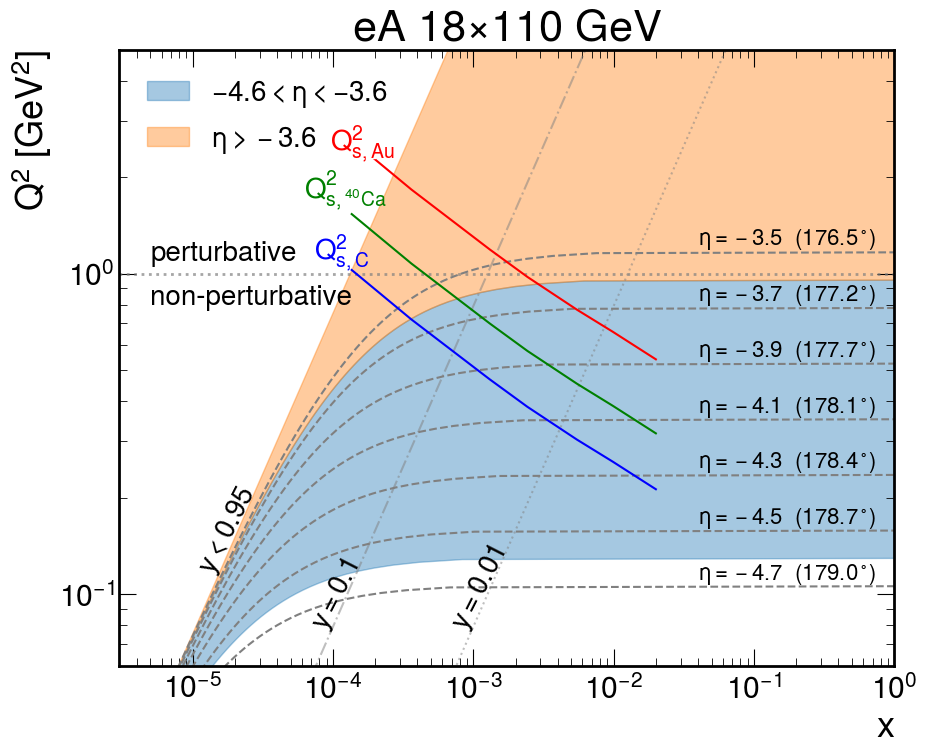

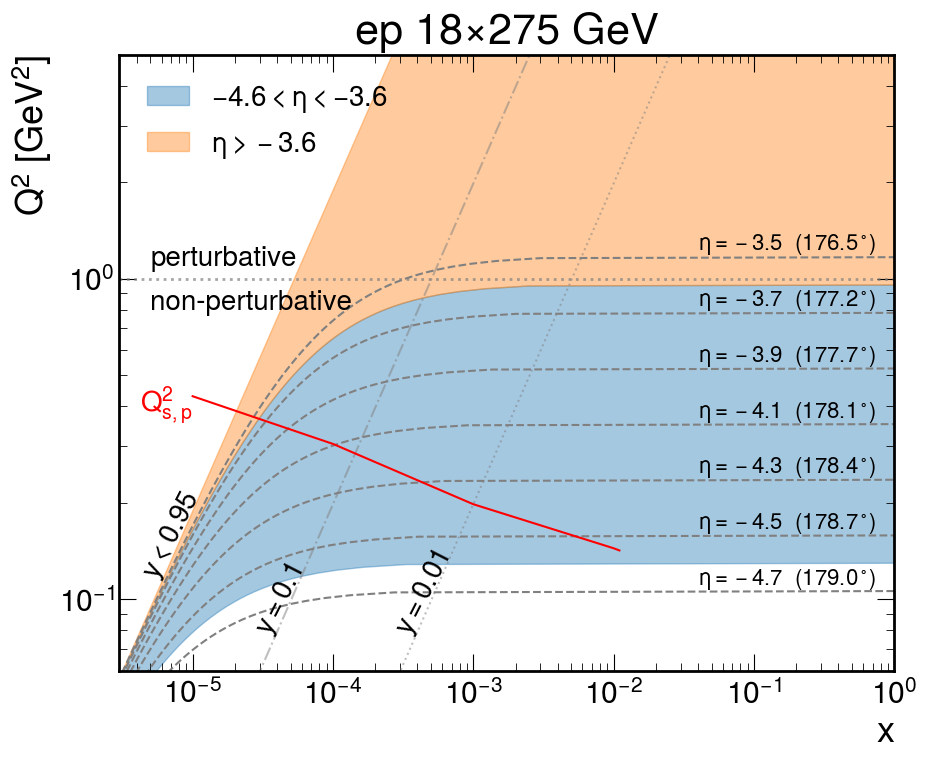

In [17]:
plt.subplots(1,1, figsize=(10,8))
x_Q2_plot_new(maxy=0.95, mineta_=-4.6, maxeta_=-3.6, bs=BeamSetting(18,110), title_tag='$eA$')
x=np.linspace(*plt.gca().get_xlim())
#plt.plot(x,Q2_s_A(197,x), color='r')
#plt.plot(x,Q2_s_A(1,x), color='g')
#add curves for p, Ca40 and Au
x=np.array([1e-4, 1e-3, 1e-2])

#plot_Qs(197, [0.127,0.157,0.187], "\\rm Au", 'r', 8e-5, 2e-2)
#use yellow report numbers for Au instead of calculating them ourselves
xy=[0.0000799, 3.24,
0.000136, 2.61,
0.000362, 1.83,
0.00131, 1.19,
0.00243, 0.977,
0.00548, 0.772,
0.00986, 0.659]
#extrapolate to match where the other curves end
xy+=[0.02, 0.659*(0.02/0.00986)**-.28]

plt.plot(xy[2::2],xy[3::2], color='r')
plt.gca().fill_between((1e-4,2e-4), (2.3,2.3), (3,3), color='w', zorder=9)
plt.text(1.2e-4*2.3, 2.4, "$Q^2_{s,Au}$", color='r', fontsize=20, ha='right', rotation=0, zorder=10)

plt.plot(xy[2::2],np.array(xy[3::2])*(40/197)**(1/3), color='g')
plt.text(1.2e-4*2, 1.7, "$Q^2_{s,^{40}\\rm Ca}$", color='g', fontsize=20, ha='right', rotation=0)

plt.plot(xy[2::2],np.array(xy[3::2])*(12/197)**(1/3), color='b')
plt.text(1.2e-4*1.5, 1.1, "$Q^2_{s,\\rm C}$", color='b', fontsize=20, ha='right', rotation=0)


#plot_Qs(40, [0.086,0.112,0.142], "^{40}\\rm Ca", 'g', 5e-5, 2e-2)
#plot_Qs(12, [0.06,0.082,0.105], "\\rm C", 'b', 3e-5,2e-2)






plt.savefig('images/x_Q2_eA.pdf')
plt.show()
plt.subplots(1,1, figsize=(10,8))
x_Q2_plot_new(maxy=0.95, mineta_=-4.6, maxeta_=-3.6, bs=BeamSetting(18,275), title_tag='$ep$')


plot_Qs(1, [0.153,0.198,0.288], "p", 'r', 1e-5,1.1e-2)

# Q2=1**(1/3)*(x/1e-3)**-.3*np.array([0.153,0.198,0.288])
# plt.plot(x,Q2, color='r')
# plt.text(x[1], Q2[1]*1.1, "$Q^2_{s,p}$", color='r', fontsize=16)
plt.savefig('images/x_Q2_ep.pdf')

In [18]:
gran=0.5
z=-236

print(f"{10*gran} mm at z={z} cm: dtheta={gran/z/np.sqrt(12):.2}")

5.0 mm at z=-236 cm: dtheta=-0.00061


In [19]:
def Q2resfrac(eta, Eresfrac, thetares):
    theta=get_theta(eta)
    return np.hypot(Eresfrac, thetares*np.tan(theta/2))

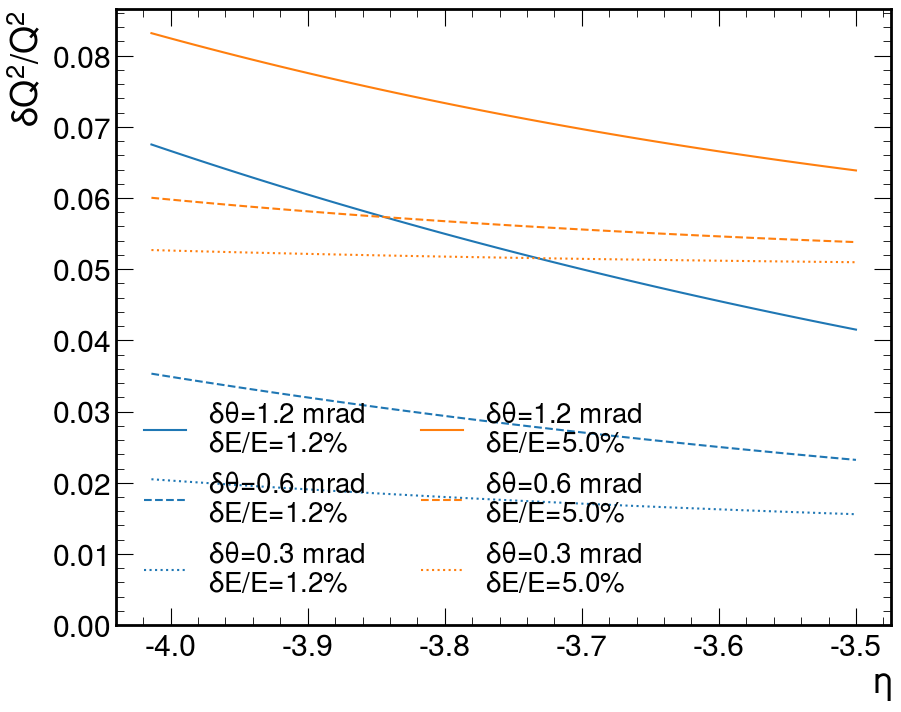

In [20]:

eta=np.linspace(min_eta, -3.5)
linestyles='- -- :'.split()
colors='tab:blue tab:orange tab:green'.split()
for i,Eresfrac in enumerate((0.012, 0.05)):
    for j,thetares in enumerate((0.0012, 0.0006, 0.0003)):
        plt.plot(eta, Q2resfrac(eta, Eresfrac, thetares), 
                 label=f'$\delta\\theta$={1000*thetares:.1f} mrad\n$\delta E/E$={100*Eresfrac:.1f}%',
                color=colors[i], ls=linestyles[j])
    plt.text(-3.75, Eresfrac-.005, f"", fontsize=20)
        
plt.ylim(0)
plt.xlabel('$\\eta$')
plt.ylabel('$\\delta Q^2/Q^2$')
plt.legend(ncol=2, fontsize=20)
plt.show()

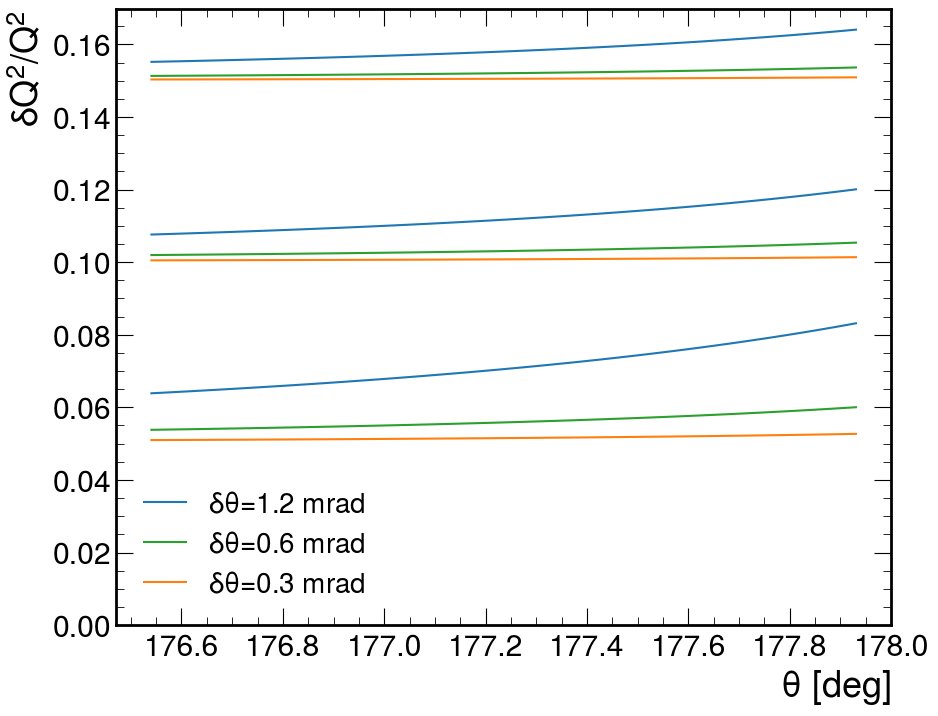

In [21]:
eta=np.linspace(min_eta, -3.5)
for i,Eresfrac in enumerate((0.15, 0.10, 0.05)):
    colors='tab:blue tab:green tab:orange'.split()
    for j,thetares in enumerate((0.0012, 0.0006, 0.0003)):
        plt.plot(get_theta(eta)*180/np.pi, Q2resfrac(eta, Eresfrac, thetares), 
                 label=f'$\delta\\theta$={1000*thetares:.1f} mrad' if i == 0 else None,
                color=colors[j])
    #plt.text(-170, Eresfrac-.005, f"$\delta E/E$={100*Eresfrac:.0f}%", fontsize=20)
        
plt.ylim(0)
plt.xlabel('$\\theta$ [deg]')
plt.ylabel('$\\delta Q^2/Q^2$')
plt.legend(ncol=1, fontsize=20)


plt.show()

In [22]:


def maxE_with_crossing(bs, eta, thcross=0.025, phi=0):
    theta=get_theta(eta)
    return bs.Pbeam*bs.Ebeam/(bs.Pbeam*np.sin(theta/2)**2+bs.Ebeam*(1-np.cos(theta)*np.cos(thcross)-np.sin(thcross)*np.sin(theta)*np.cos(phi)))

In [23]:
bs=beam_settings[0]
mx=0
for phi in np.linspace(-np.pi,np.pi,50):
    for eta in np.linspace(-4.1, -3.5, 50):
        for E in np.linspace(minE(bs, eta, 0.95),bs.Ebeam, 500):
            x=x_Q2(bs, eta, E, thcross=0.025, phi=phi)[0]
            xnom= x_Q2(bs, eta, E, thcross=0)[0]
            if x>1 or xnom>1 or x<0 or xnom<0:
                continue
            
            a=abs(x/xnom-1)
            if a>mx:
                mx=a
                Eworst, etaworst=E,eta
                xworst=x
                xnomworst=xnom
print(Eworst, etaworst, mx, xworst,xnomworst)



#plt.plot(phi, x_Q2(bs, eta, E, thcross=0.025, phi=phi)[0])

18.0 -3.6959183673469385 14.078296655834368 0.9869430538365428 0.06545454545455284


In [24]:
x_Q2(bs, -3.7, maxE(bs, -3.7))

(0.0003600834447381431, 0.7129652205815236)

In [25]:
y(bs, -3.7, maxE(bs, -3.7))

0.10000000000000003

In [28]:
import ROOT

Welcome to JupyROOT 6.26/06


Text(0, 1, '$Q^2$ [GeV$^2$]')

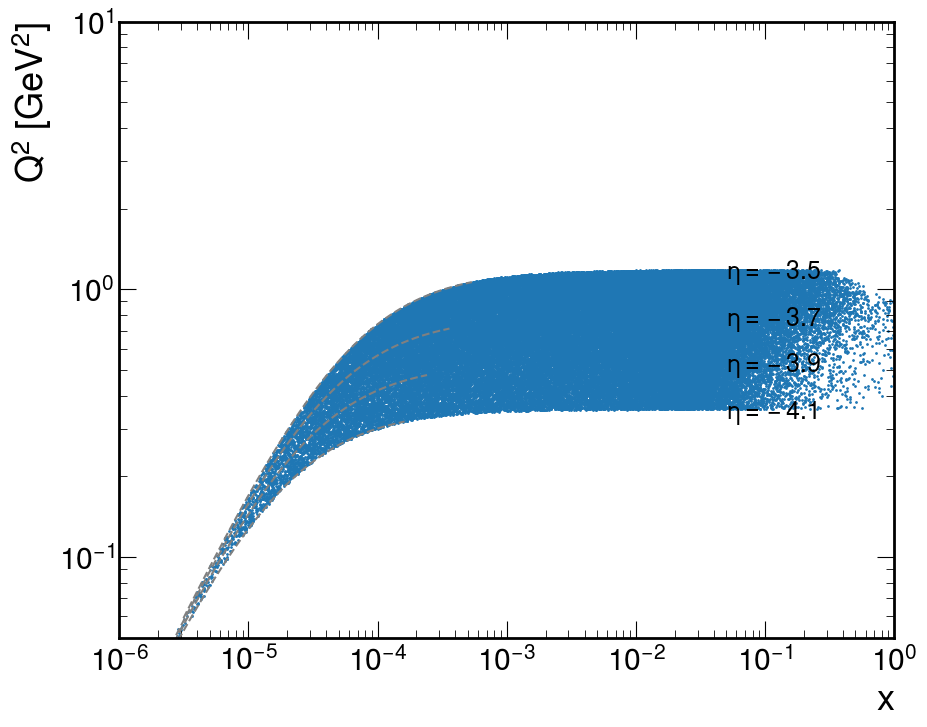

In [29]:
# mess around with non-vanishing crossing angles.  
# Run an MC and see if there are events with x, Q^2 outside the range obtained without crossing angle.  

thcross=0.025
eb=ROOT.TLorentzVector(0, 0,-18,18)
pb=ROOT.TLorentzVector(-275*np.sin(thcross),0, 275*np.cos(thcross), np.hypot(275, 0.938))
zstar=pb.Vect()


#4 mm + 1 mm + LD hadron beampipe radius
thstar_max=np.pi-(1.6+4+1)/271

import random
r=random.Random()
Q2s, xs=[],[]
for i in range(100000):
    phi = r.uniform(0, np.pi)
    
    #weird way to get a non-uniform distribution in E with fair statistics at large E
    a=r.uniform(0, 4)
    E = eb.E()*r.uniform( 1-.1**a,1)
    
    theta = r.uniform(get_theta(-4.1), get_theta(-3.5))
    eprime = ROOT.TLorentzVector(E*np.cos(phi)*np.sin(theta), E*np.sin(phi)*np.sin(theta),E*np.cos(theta),E)
    q=eb-eprime
    Q2=-(q*q)
    denom= 2*(q*pb)
    x=Q2/denom
    y=(pb*q)/(eb*pb)
    #print(y)
    if eprime.Angle(zstar)>thstar_max:
        continue

    if y<0.95 and y>0 and x<1 and x>0:

        Q2s.append(Q2)
        xs.append(x)
for eta in np.linspace(-4.1, -3.5, 4):
    E=np.linspace(.9, maxE(bs, eta), 50)
    plt.plot(*x_Q2(bs, eta, E), linestyle='--', color='0.5')
    plt.text(0.05, 1.03*x_Q2(bs, eta, E[-1])[1], f"$\\eta={eta:.1f}$", ha='left', fontsize=18)
plt.scatter(xs, Q2s,1)
#print(Q2s)
plt.yscale('log')
plt.xscale('log')
plt.xlabel("x")
plt.ylim(.05, 10)
plt.xlim(1e-6, 1)
plt.ylabel("$Q^2$ [GeV$^2$]")


In [31]:
def min_E_plot(Ebeam=18, ymax=0.95, Q2min=0.1,**arg):
    eta=np.linspace(-4.8, -3.0,200)
    theta=get_theta(eta)
    Emax_from_y=(1-ymin)*2*Ebeam/(1-np.cos(theta))
    Emax=Emax_from_y
    
    Emin_from_y=(1-ymax)*2*Ebeam/(1-np.cos(theta))
    Emin_from_Q2=Q2min/(4*Ebeam*np.sin((np.pi-theta)/2)**2)
    Emin=Emin_from_y*(Emin_from_Q2<Emin_from_y)+Emin_from_Q2*(Emin_from_Q2>=Emin_from_y)
    
    slc=Emax>Emin
    
    
    plt.plot(eta,(1-0.01)*2*Ebeam/(1-np.cos(theta)), linestyle='--', label='y=0.01')
    
    plt.plot(eta,(1-0.1)*2*Ebeam/(1-np.cos(theta)), linestyle='--', label='y=0.1')
    
    #plt.fill_between(eta[slc], Emin[slc], Emax[slc], label=f"$E_{{\\rm beam}}={Ebeam}$ GeV", alpha=0.3)
    r=plt.plot(eta[slc], Emin[slc],**arg)
    #plt.

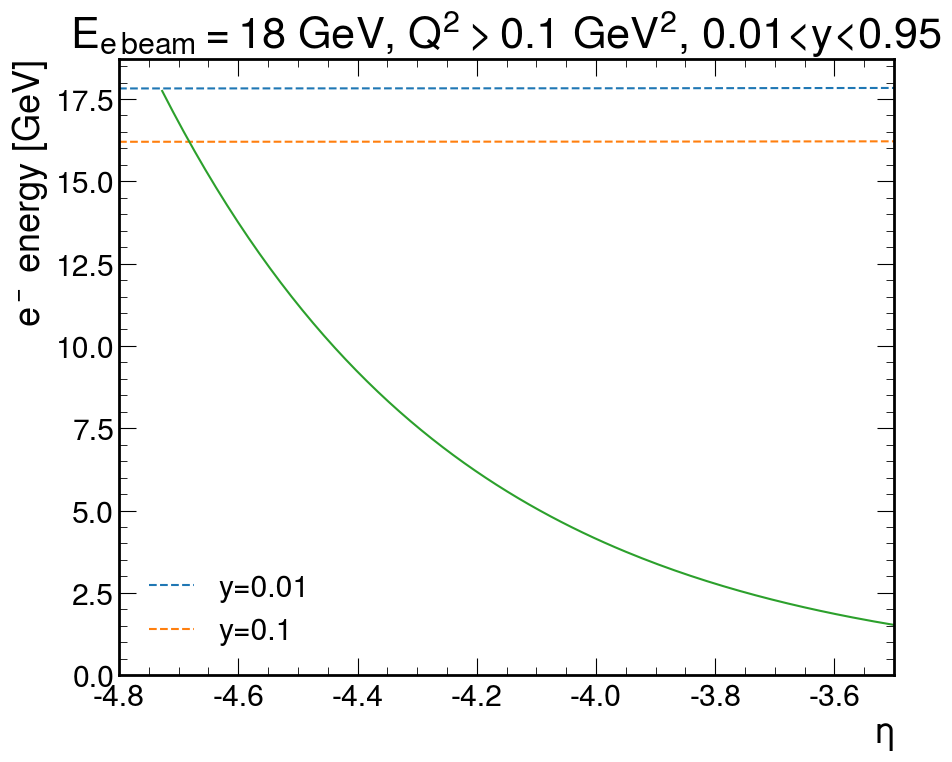

In [32]:
Q2min=0.1
ymin=0.01
ymax=0.95
Ebeam=18
plt.title(f"$E_{{e\,beam}}={Ebeam}$ GeV, $Q^2>{Q2min:.1}$ GeV$^2$, {ymin:.2f}<y<{ymax:.2f}")
plt.ylabel("$e^-$ energy [GeV]")
plt.xlabel("$\\eta$")
min_E_plot(Ebeam, )
#min_E_plot(10)
#min_E_plot(5)
plt.ylim(0)
plt.xlim(-4.8, -3.5)
plt.legend(loc='lower left')

In [33]:
def min_E_plot_new(Ebeam=18, ycontours=(0.01, 0.1), Q2contours=(0.1, 0.25, 0.5, .75, 1),**arg):
    eta=np.linspace(-4.8, -3.0,20)
    theta=get_theta(eta)
    Emax=2*Ebeam/(1-np.cos(theta))
    
    ls=['--', ':', '-.']
    for i,y in enumerate(ycontours):
        E=(1-y)*2*Ebeam/(1-np.cos(theta))
        plt.plot(eta,E, ls=ls[i], color='0.5')
        plt.text(-4.5, E[4]+.1, f"$y={y}$", fontsize=20)
        
    ls=['-', '--', '-.', ':',(0, (5,5))]
    for i,Q2 in enumerate(Q2contours):
        
        eta=np.linspace(-4.8, -3.0,200)
        theta=get_theta(eta)
        Emax=(1-0.01)*2*Ebeam/(1-np.cos(theta))
        
        E=Q2/(4*Ebeam*np.sin((np.pi-theta)/2)**2)
        slc=E<Emax
        plt.plot(eta[slc], E[slc], linestyle=ls[i],label=f'$Q^2$={Q2:.2f} GeV$^2$')
        
        
    plt.ylabel("Minimum $e^-$ energy [GeV]")
    plt.xlabel("$\\eta$")
    plt.ylim(0, 20)
    plt.xlim(-4.8, -3.5)
    plt.legend(fontsize=20)

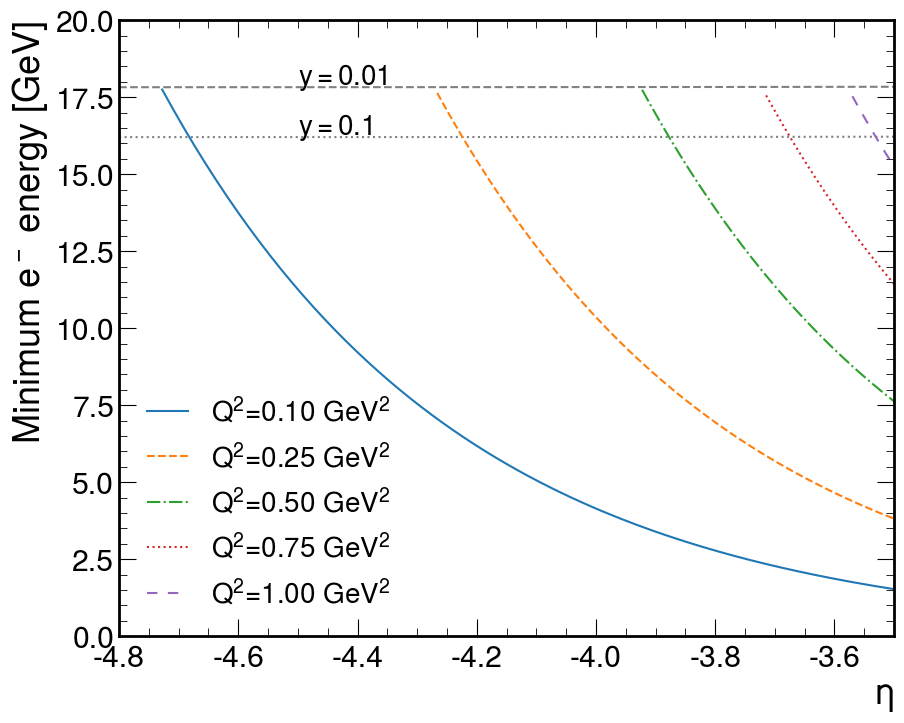

In [34]:
min_E_plot_new()
plt.savefig("images/energy_vs_theta.pdf")